In [1]:
import numpy as np
from SimPEG import Mesh, Utils, Maps
from SimPEG.EM import FDEM, TDEM, mu_0
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver as Solver
import h5py
%matplotlib inline

# set a nice colormap
plt.set_cmap(plt.get_cmap('viridis'))

# Model Parameters

In [2]:
sigmaair = 1e-8  # air
sigmaback = 1e-2  # background

sigmacasing = 5.5e6  # casing
sigmainside = 1  # inside the casing
mucasing = 50  # casing permeability

casing_l = 1000   # length of the casing
casing_d = 10e-2  # 10cm diameter casing
casing_t = 1e-2   # 1cm thickness

# layer
sigmalayer = sigmaback
layer_z = np.r_[-1000., -900.]

# # 3D body
# sigmablock =  2.
# block_x = np.r_[75., 475.]
# block_y = np.r_[-125, 125.]
# block_z = layer_z

# Survey Params
freqs = np.r_[1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1]  # frequencies 0.5
dsz = -950.  # down-hole z source location

src_a = np.r_[0., 0., dsz]
src_b = np.r_[1e4, 0.,  0.]  # return electrode is a ring, 200

In [3]:
# useful quantities to work in
casing_r = casing_d/2.
casing_a = casing_r - casing_t/2.  # inner radius
casing_b = casing_r + casing_t/2.  # outer radius
casing_z = np.r_[-casing_l, 0.]

In [4]:
# -------------- Mesh Parameters ------------------ #
# x-direction
csx1, csx2 = 2.5e-3, 25.  # fine cells near well bore
pfx1, pfx2 = 1.3, 1.5  # padding factors: fine -> uniform
ncx1 = np.ceil(casing_b/csx1+2)  # number of fine cells
                                      # (past casing wall)
dx2 = 1000.  # uniform mesh out to here
npadx2 = 23  # padding out to infinity

# z-direction
csz = 0.05  # finest z-cells
nza = 10  # number of fine cells above air-earth interface
pfz = pfx2 # padding factor in z-direction

# ------------- Assemble the Cyl Mesh ------------- #
# pad nicely to second cell size
npadx1 = np.floor(np.log(csx2/csx1) / np.log(pfx1))
hx1a = Utils.meshTensor([(csx1, ncx1)])
hx1b = Utils.meshTensor([(csx1, npadx1, pfx1)])
dx1 = sum(hx1a)+sum(hx1b)
dx1 = np.floor(dx1/csx2)
hx1b *= (dx1*csx2 - sum(hx1a))/sum(hx1b)

# second chunk of mesh
ncx2 = np.ceil((dx2 - dx1)/csx2)
hx2a = Utils.meshTensor([(csx2, ncx2)])
hx2b = Utils.meshTensor([(csx2, npadx2, pfx2)])
hx = np.hstack([hx1a, hx1b, hx2a, hx2b])

# cell size, number of core cells, number of padding cells in the
# x-direction
ncz = np.int(np.ceil(np.diff(casing_z)[0]/csz))+10
npadzu, npadzd = 38, 38

# vector of cell widths in the z-direction
hz = Utils.meshTensor(
        [(csz, npadzd, -pfz), (csz, ncz), (csz, npadzu, pfz)]
        )

# primary mesh
mesh = Mesh.CylMesh(
    [hx, 1., hz], [0., 0., -np.sum(hz[:npadzu+ncz-nza])]
    )

print(
    'Cyl Mesh Extent xmax: {},: zmin: {}, zmax: {}'.format(
        mesh.vectorCCx.max(),
        mesh.vectorCCz.min(),
        mesh.vectorCCz.max()
    )
)

print(mesh.nC)
print([500./np.sqrt(sigmaback*f) for f in freqs])
print([500./np.sqrt(sigmacasing*f) for f in freqs])

Cyl Mesh Extent xmax: 702446.341501,: zmin: -615296.090052, zmax: 614296.590053
2450492
[500000.0, 158113.88300841895, 50000.0, 15811.388300841898, 7071.0678118654751, 5000.0]
[21.320071635561042, 6.7419986246324211, 2.1320071635561044, 0.67419986246324204, 0.30151134457776363, 0.21320071635561044]


# plot model

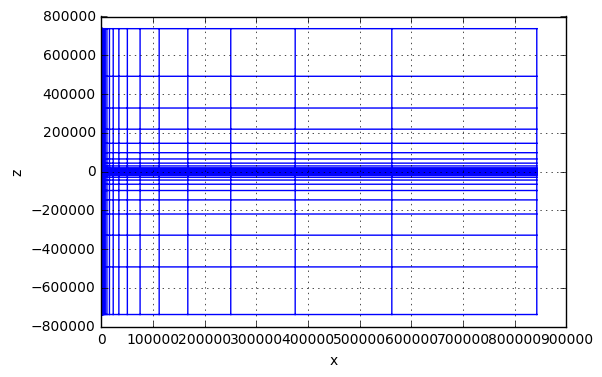

In [5]:
mesh.plotGrid()

In [6]:
indActive=mesh.gridCC[:,2] <= 0.
casingMap = Maps.ParametrizedCasingAndLayer(mesh, indActive=indActive, slope=1e8)
actMap_sigma = Maps.InjectActiveCells(mesh, indActive=indActive, valInactive=np.log(sigmaair))
actMap_mu = Maps.InjectActiveCells(mesh, indActive=indActive, valInactive=mu_0)
expMap = Maps.ExpMap(mesh)

sigmaMap = expMap * actMap_sigma * casingMap
muMap = actMap_mu * casingMap

sigma_m = np.r_[
    np.log(sigmaback), np.log(sigmalayer), np.log(sigmacasing), np.log(sigmainside),
    layer_z.mean(), layer_z[1] - layer_z[0], casing_r, casing_t, 
    casing_z[0], casing_z[1]
]

mu_m = np.r_[
    mu_0, mu_0, mucasing*mu_0, mu_0,
    layer_z.mean(), layer_z[1] - layer_z[0], casing_r, casing_t, 
    casing_z[0], casing_z[1]
]

In [7]:
%%time
sigma = sigmaMap * sigma_m
mu = muMap * mu_m

CPU times: user 23.2 s, sys: 511 ms, total: 23.7 s
Wall time: 24.4 s


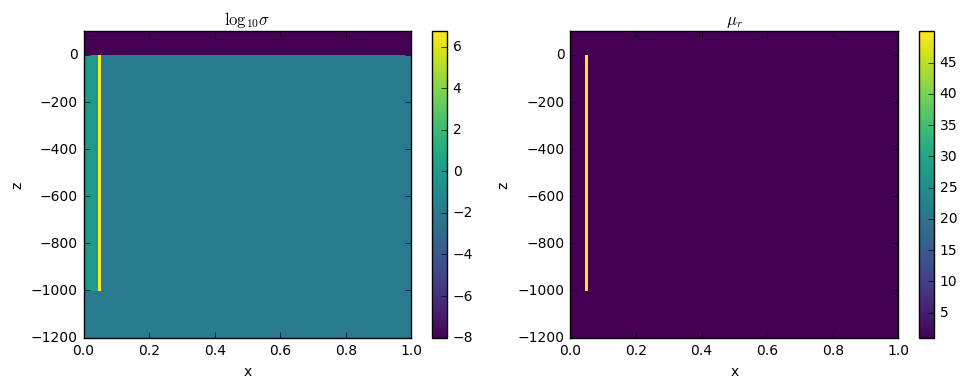

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

xlim = [0., 1.]
zlim = [-1200., 100.]

plt.colorbar(mesh.plotImage(np.log10(sigma), ax=ax[0])[0], ax=ax[0])
plt.colorbar(mesh.plotImage(mu/mu_0, ax=ax[1])[0], ax=ax[1])

ax[0].set_xlim(xlim)
ax[1].set_xlim(xlim)

ax[0].set_ylim(zlim)
ax[1].set_ylim(zlim)

ax[0].set_title('$\log_{10}\sigma$')
ax[1].set_title('$\mu_r$')

plt.tight_layout()

# Set up the Source

In [9]:
# downhole source
dg_x = np.zeros(mesh.vnF[0], dtype=complex)
dg_y = np.zeros(mesh.vnF[1], dtype=complex)
dg_z = np.zeros(mesh.vnF[2], dtype=complex)

# vertically directed wire in borehole
# go through the center of the well
dgv_indx = (mesh.gridFz[:, 0] < mesh.hx.min())
dgv_indz = ((mesh.gridFz[:, 2] >= src_a[2])
            & (mesh.gridFz[:, 2] <= src_b[2] + 2*mesh.hz.min()))
dgv_ind = dgv_indx & dgv_indz
dg_z[dgv_ind] = -1.

# couple to the casing downhole - top part
dgh_indx = mesh.gridFx[:, 0] <= casing_a #+ mesh.hx.min()*2

# couple to the casing downhole - bottom part
dgh_indz2 = ((mesh.gridFx[:, 2] <= src_a[2]) &
             (mesh.gridFx[:, 2] > src_a[2] - mesh.hz.min()))
dgh_ind2 = dgh_indx & dgh_indz2
dg_x[dgh_ind2] = 1.

# horizontally directed wire
sgh_indx = (mesh.gridFx[:, 0] <= src_b[0])
sgh_indz = ((mesh.gridFx[:, 2] > mesh.hz.min())
            & (mesh.gridFx[:, 2] < 2*mesh.hz.min()))
sgh_ind = sgh_indx & sgh_indz
dg_x[sgh_ind] = -1.

# return electrode
sgv_indx = (
    (mesh.gridFz[:, 0] > src_b[0]*0.9) &
    (mesh.gridFz[:, 0] < src_b[0]*1.1)
)
sgv_indz = (
    (mesh.gridFz[:, 2] >= -mesh.hz.min()) &
    (mesh.gridFz[:, 2] < 2*mesh.hz.min())
)
sgv_ind = sgv_indx & sgv_indz
dg_z[sgv_ind] = 1.

# assemble the source (downhole grounded primary)
dg = np.hstack([dg_x, dg_y, dg_z])
dg_p = [
    FDEM.Src.RawVec_e([], _, dg/mesh.area) for _ in freqs
]

(-951.0, -949.0)

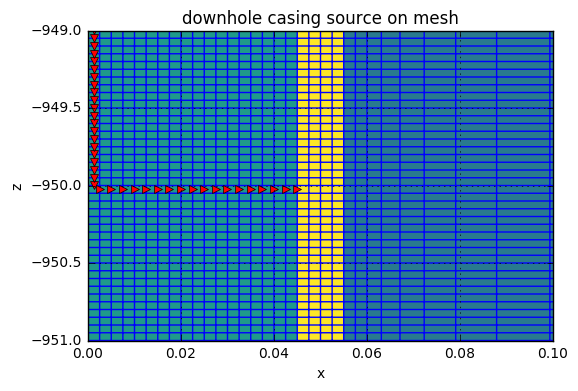

In [10]:
# Plot the source to make sure the path is infact
# connected

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
mesh.plotImage(np.log10(sigma), ax=ax)
mesh.plotGrid(ax=ax)
ax.plot(mesh.gridFz[dgv_ind, 0], mesh.gridFz[dgv_ind, 2], 'rv')
ax.plot(mesh.gridFx[dgh_ind2, 0], mesh.gridFx[dgh_ind2, 2], 'r>')
ax.plot(mesh.gridFz[sgv_ind, 0], mesh.gridFz[sgv_ind, 2], 'r^')
ax.plot(mesh.gridFx[sgh_ind, 0], mesh.gridFx[sgh_ind, 2], 'r<')

ax.set_title('downhole casing source on mesh')

ax.set_xlim([0, 0.1])
ax.set_ylim([-951., -949.])


# Problem and Survey

In [11]:
prob = FDEM.Problem3D_h(mesh, sigma=sigma, muMap=muMap)
survey = FDEM.Survey(dg_p)

prob.pair(survey)

In [12]:
def MuCasingModel(mucasing):
    return np.r_[
        mu_0, mu_0, mucasing*mu_0, mu_0,
        layer_z.mean(), layer_z[1] - layer_z[0], casing_r, casing_t, 
        casing_z[0], casing_z[1]
    ]

In [13]:
# create a file to store results
results = h5py.File("MagneticPermeabilityImpacts.hdf5", "w")

In [14]:
%%time
muModels = [1., 50., 100., 150., 200.]
fields = {}
for muMod in muModels:
    tag = int(muMod)
    print('solving mu = {}mu_0'.format(tag))
    curMu = MuCasingModel(muMod)
    fields[tag] = prob.fields(curMu)
    dbentry = "fields_{tag}".format(tag=tag)
    results.create_dataset(dbentry, data=fields[tag][:,'hSolution'])
    print('... saved fields_{tag}'.format(tag=tag))

solving mu = 1mu_0
... saved fields_1
solving mu = 50mu_0
... saved fields_50
solving mu = 100mu_0
... saved fields_100
solving mu = 150mu_0
... saved fields_150
solving mu = 200mu_0
... saved fields_200
CPU times: user 36min 5s, sys: 4min 15s, total: 40min 21s
Wall time: 25min 35s


In [15]:
print("hSolution_fields_{0!s}mu".format(int(10.)))

hSolution_fields_10mu


In [22]:
from matplotlib.colors import LogNorm
def plotCurrentDensity(
    fields_j, saveFig=False,
    figsize=(4, 5), fontsize=12, csx=5., csz=5.,
    xmax=1000., zmin=0., zmax=-1200. 
): 
    csx, ncx = csx, np.ceil(xmax/csx)
    csz, ncz = csz, np.ceil(-zmax/csz)

    xlim=[0., xmax]
    ylim=[zmax, zmin]
    # define the tensor mesh
    meshcart = Mesh.TensorMesh(
        [[(csx, ncx)], [(csx, 1)], [(csz, ncz)]], [0, -csx/2., zmax]
    )
        
    projF = mesh.getInterpolationMatCartMesh(meshcart, 'F')

    jcart = projF*fields_j
    print jcart.shape, jcart.real.max(), jcart.real.min()
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    if saveFig is True:
        # this looks obnoxious inline, but nice in the saved png
        f = meshcart.plotSlice(
            jcart.real, normal='Y', vType='F', view='vec',
            pcolorOpts={
                'norm': LogNorm(), 'cmap': plt.get_cmap('viridis')
            },
            streamOpts={'arrowsize': 8, 'color': 'k'},
            ax=ax
        )
    else:
        f = meshcart.plotSlice(
            jcart.real, normal='Y', vType='F', view='vec',
            pcolorOpts={
                'norm': LogNorm(), 'cmap': plt.get_cmap('viridis')
            },
            ax=ax
        )
    plt.colorbar(f[0], label='real current density (A/m$^2$)')

    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title('Primary Current Density')
    ax.set_xlabel('radius (m)', fontsize=fontsize)
    ax.set_ylabel('z (m)', fontsize=fontsize)

    if saveFig is True:
        fig.savefig('primaryCurrents', dpi=300, bbox_inches='tight')

    return ax

(363008, 1) 16.6384419667 -0.00879472843985
CPU times: user 1min 32s, sys: 4.2 s, total: 1min 36s
Wall time: 1min 53s


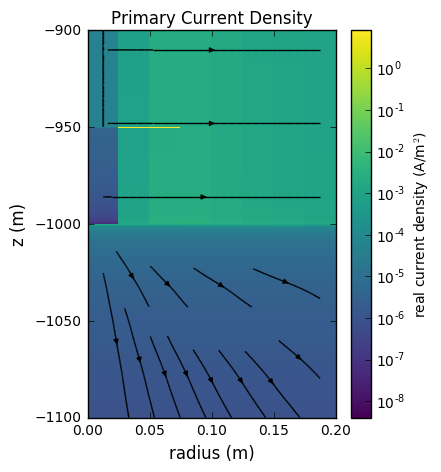

In [265]:
%%time
src=survey.srcList[0]
ax = plotCurrentDensity(fields[100][src, 'j'], csx=0.0025, csz=0.1, xmax=0.2, zmin=-900., zmax=-1100.)
#ax.axis('equal', adjustable='box')

In [43]:
# find indices where the cell centers are in the casing
casing_ind = sigma_m.copy()
casing_ind[[0, 1, 3]] = 0. # zero outside casing
casing_ind[2] = 1. # 1 inside casing 

actMap_Zeros = Maps.InjectActiveCells(mesh, indActive, 0.)

indCasing = actMap_Zeros * casingMap * casing_ind

(-1100.0, 10.0)

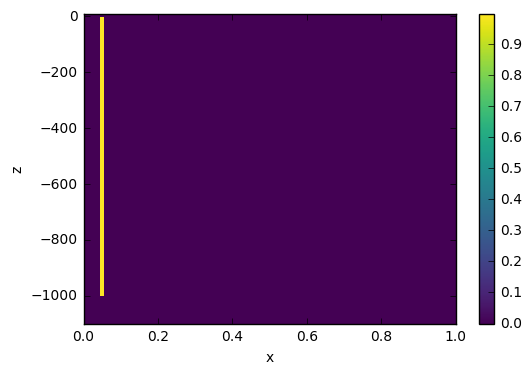

In [44]:
# plot to sanity-check
fig, ax = plt.subplots(1,1)
f = mesh.plotImage(indCasing, ax=ax)
plt.colorbar(f[0])
ax.set_xlim([0., 1.])
ax.set_ylim([-1100., 10.])

In [172]:
mur = 100
j = fields[mur][:,'j']
jA = Utils.sdiag(mesh.area) * j

print jA.shape

(4901106, 6)


In [173]:
casing_faces = mesh.aveF2CC.T * indCasing
casing_faces[casing_faces < 0.25] = 0

print casing_faces.nonzero()

(array([   4654,    4655,    4656, ..., 4895025, 4895026, 4895027]),)


(-950.0, -951.0)

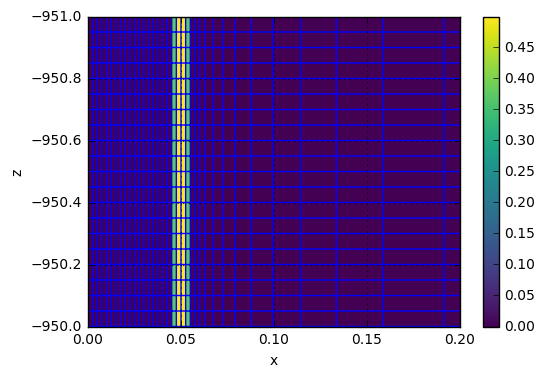

In [174]:
fig, ax = plt.subplots(1)
f = mesh.plotImage(mesh.aveF2CC * casing_faces, ax=ax)
plt.colorbar(f[0])
mesh.plotGrid(ax=ax)
ax.set_xlim([0., 0.2])
ax.set_ylim([-950., -951.])


In [209]:
%%time 
JxCasing = {}
JzCasing = {}

for mur in muModels: 
    j = fields[mur][:,'j']
    jA = Utils.sdiag(mesh.area) * j

    jACasing = Utils.sdiag(casing_faces) * jA

    jxCasing = []
    jzCasing = []

    for freqind in range(len(freqs)):
        jxCasing.append(jACasing[:mesh.nFx,freqind].reshape(mesh.vnFx[0], mesh.vnFx[2], order='F'))
        jzCasing.append(jACasing[mesh.nFx:,freqind].reshape(mesh.vnFz[0], mesh.vnFz[2], order='F'))
    
    JxCasing[mur] = jxCasing
    JzCasing[mur] = jzCasing

In [323]:
def plot_over_freq(mur=1, subtract=None, real_or_imag='real', ax=None):
    print("mu = {} mu_0".format(mur))
    jxCasing = JxCasing[mur]
    jzCasing = JzCasing[mur]

    if ax is None: 
        fig, ax = plt.subplots(2,1, figsize=(10,8))
        
    for a in ax:
        a.grid(which='both', linestyle='-', linewidth=0.4, color=[0.8, 0.8, 0.8], alpha=0.5)
        a.semilogy([src_a[2], src_a[2]], [1e-14, 1], color=[0.3, 0.3, 0.3])
        a.set_xlim([-1100., 0.])
    #     a.set_ylim([1e-3, 1.])
        a.invert_xaxis()

    col = ['b', 'g', 'r', 'c', 'm', 'y']

    leg = []
    for i,f in enumerate(freqs):
        jx, jz = jxCasing[i], jzCasing[i]
        
        if subtract is not None:
            print('subtracting {} mu_0 results'.format(subtract))
            jx += -JxCasing[subtract][i]
            jz += -JzCasing[subtract][i]

        Iz = getattr(jz.sum(0), real_or_imag)
        leg.append(ax[0].semilogy(mesh.vectorNz, Iz, '-{}'.format(col[i]), label="{} Hz".format(f)))
        ax[0].semilogy(mesh.vectorNz,-Iz,'--{}'.format(col[i]))

        Ix = getattr(jx.sum(0), real_or_imag)
        ax[1].semilogy(mesh.vectorCCz, Ix, '-{}'.format(col[i]))
        ax[1].semilogy(mesh.vectorCCz,-Ix,'--{}'.format(col[i]))

    if real_or_imag == 'real': 
        if subtract is None:
            ax[0].set_ylim([1e-3, 1.])
            ax[1].set_ylim([3e-5, 2e-4])
        else:
            ax[0].set_ylim([1e-3, 1.])
            ax[1].set_ylim(1e-5, 2e-4)

    elif real_or_imag == 'imag' and subtract is None:
        ax[0].set_ylim([1e-9, 1e-2])
        ax[1].set_ylim([1e-12, 1e-5])

    ax[0].legend(bbox_to_anchor=[1.15,1])
    plt.show()
    
    return ax

In [316]:
from ipywidgets import interact, IntSlider, ToggleButtons

mu = 100.0 mu_0


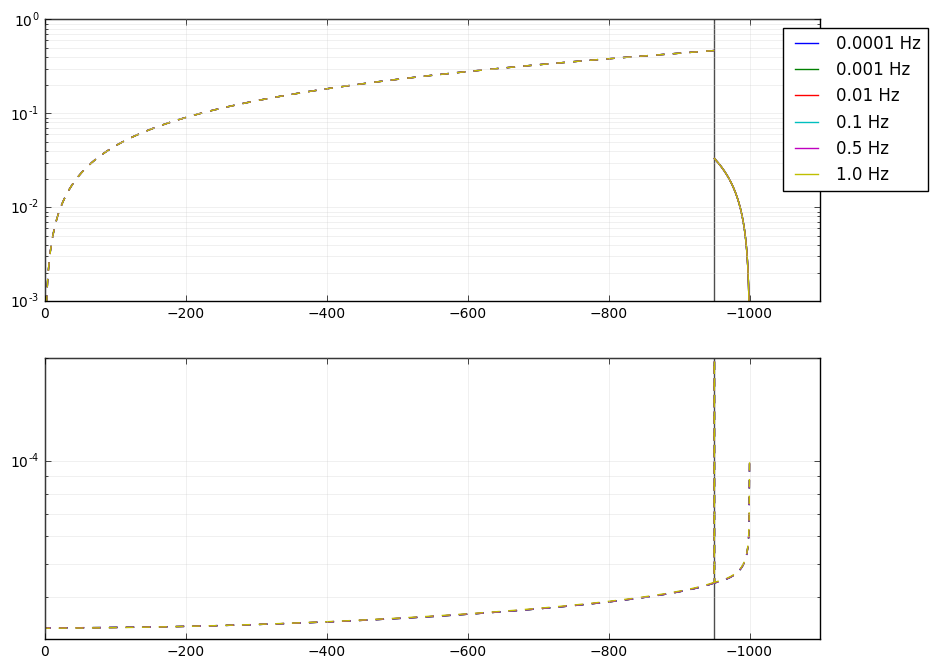

In [324]:
def plotMe_freq(muopt, reim):
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    mur = muModels[muopt]
    plot_over_freq(mur, subtract=None, real_or_imag=reim, ax=ax)  

interact(plotMe_freq, muopt=IntSlider(min=0., max=len(muModels)-1), reim=ToggleButtons(options=['real', 'imag']))

In [325]:
def plot_over_mu(freqind=0, real_or_imag='real', subtract=None, ax=None):
    print("{} Hz".format(freqs[freqind]))
    
    if ax is None: 
        fig, ax = plt.subplots(2,1, figsize=(10,8))
        
    for a in ax:
        a.grid(which='both', linestyle='-', linewidth=0.4, color=[0.8, 0.8, 0.8], alpha=0.5)
        a.semilogy([src_a[2], src_a[2]], [1e-14, 1], color=[0.3, 0.3, 0.3])
        a.set_xlim([-1100., 0.])
    #     a.set_ylim([1e-3, 1.])
        a.invert_xaxis()

    col = ['b', 'g', 'r', 'c', 'm', 'y']

    leg = []
    for i, mur in enumerate(muModels):

        jxCasing = JxCasing[mur]
        jzCasing = JzCasing[mur]

        jx, jz = jxCasing[freqind], jzCasing[freqind]

        Iz = getattr(jz.sum(0), real_or_imag)
        leg.append(ax[0].semilogy(mesh.vectorNz, Iz, '-{}'.format(col[i]), label="{} $\mu_0$".format(mur)))
        ax[0].semilogy(mesh.vectorNz,-Iz,'--{}'.format(col[i]))

        Ix = getattr(jx.sum(0), real_or_imag)
        ax[1].semilogy(mesh.vectorCCz, Ix, '-{}'.format(col[i]))
        ax[1].semilogy(mesh.vectorCCz,-Ix,'--{}'.format(col[i]))

    if real_or_imag == 'real':
        ax[0].set_ylim([1e-3, 1.])
        ax[1].set_ylim([3e-5, 2e-4])

    elif real_or_imag == 'imag':
        ax[0].set_ylim([1e-9, 1e-2])
        ax[1].set_ylim([1e-12, 1e-5])

    ax[0].legend(bbox_to_anchor=[1.15,1])
    return ax

0.0001 Hz


<function __main__.plotMe_mu>

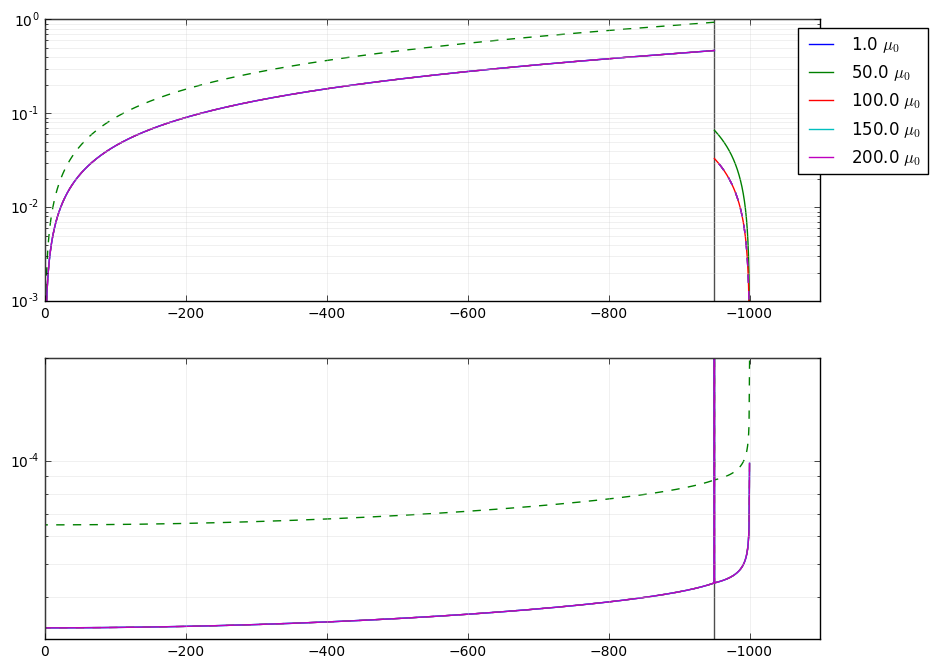

In [328]:
def plotMe_mu(freqopt, reim):
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = freqs[freqopt]
    plot_over_mu(freqopt, subtract=None, real_or_imag=reim, ax=ax)  

interact(plotMe_mu, freqopt=IntSlider(min=0., max=len(freqs)-1), reim=ToggleButtons(options=['real', 'imag']))

In [199]:
np.linalg.norm((f._MeMu.diagonal() - fields[100]._MeMu.diagonal())/mu_0)

4.898791610610246

In [ ]:
# plot current in formation

In [ ]:
# check against no casing 